In [2]:
import os
import cv2
import json
import numpy as np
import pandas as pd
import tifffile as tiff
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
with open('../data/polygons.jsonl', 'r') as json_file:
    json_list = list(json_file)

In [4]:
tiles_dicts = []
for json_str in json_list:
    tiles_dicts.append(json.loads(json_str))

In [5]:
def make_seg_mask_class1(tiles_dict):
    mask = np.zeros((512, 512), dtype=np.float32)
    for annot in tiles_dict['annotations']:
        cords = annot['coordinates']
        if annot['type'] == "blood_vessel":
            for cd in cords:
                rr, cc = np.array([i[1] for i in cd]), np.asarray([i[0] for i in cd])
                mask[rr, cc] = 1
                
    contours,_ = cv2.findContours((mask*255).astype(np.uint8), 1, 2)
    zero_img = np.zeros([mask.shape[0], mask.shape[1]], dtype="uint8")

    for p in contours:
        cv2.fillPoly(zero_img, [p], (255, 255))
    # zero_img = cv2.blur(zero_img, (6, 6))
    return zero_img    

In [6]:
blood_vessel_class = []
glomerulus_class = []
unsure_class = []

In [7]:
def make_seg_mask_class3(tiles_dict):
    # green channel encodes instances [:,:,1] 
    # red channel encodes semantic category [:,:,0] 
    mask = np.zeros((512, 512,3), dtype=np.uint8)
    instances = np.zeros((512, 512), dtype=np.uint8)
    c1 = False
    c2 = False
    c3 = False
    for annot in tiles_dict['annotations']:
        cords = annot['coordinates']
        if annot['type'] == "blood_vessel":
            for cd in cords:
                points = []
                for i in cd:
                    points.append([i[0],i[1]])
                rr, cc = np.array([i[1] for i in cd]), np.asarray([i[0] for i in cd])
                # mask[:,:,1][rr, cc] = 1
                mask[:,:,0][rr, cc] = 1
            target = instances
            points = np.array(points).astype(int).reshape((-1, 1, 2))
            cv2.fillPoly(target, [points], color=1)
            c1 = True
        elif annot['type'] == "glomerulus":
            for cd in cords:
                points = []
                for i in cd:
                    points.append([i[0],i[1]])
                rr, cc = np.array([i[1] for i in cd]), np.asarray([i[0] for i in cd])
                # mask[:,:,1][rr, cc] = 1
                mask[:,:,0][rr, cc] = 2
            target = instances
            points = np.array(points).astype(int).reshape((-1, 1, 2))
            cv2.fillPoly(target, [points], color=2)
            c2 = True
        elif annot['type'] == "unsure":
            for cd in cords:
                points = []
                for i in cd:
                    points.append([i[0],i[1]])
                rr, cc = np.array([i[1] for i in cd]), np.asarray([i[0] for i in cd])
                # mask[:,:,1][rr, cc] = 1
                mask[:,:,0][rr, cc] = 3
            target = instances
            points = np.array(points).astype(int).reshape((-1, 1, 2))
            cv2.fillPoly(target, [points], color=2)
            c3 = True
    mask[:,:,1] = instances
    if c1:
        blood_vessel_class.append(1)
    else:
        blood_vessel_class.append(0)
    if c2:
        glomerulus_class.append(1)
    else:
        glomerulus_class.append(0)
    if c3:
        unsure_class.append(1)
    else:
        unsure_class.append(0)
                
    return mask    

In [8]:
all_ids = []

In [9]:
os.makedirs('../data/train_images_class3', exist_ok=True)
os.makedirs('../data/train_masks_class3', exist_ok=True)

# for i, tldc in enumerate(tqdm(tiles_dicts)):
#     array = tiff.imread(f'../data/train/{tldc["id"]}.tif')
#     img_example = Image.fromarray(array)
#     img = np.array(img_example)
#     mask = make_seg_mask_class3(tldc)
    # plt.imshow(mask)
    # break
    
#     if np.sum(mask)>0:
#         cv2.imwrite(f'../data/train_images_class3/{tldc["id"]}.png', img)
 #        np.save(f'../data/train_masks_class3/{tldc["id"]}.npy', mask)
        # cv2.imwrite(f'../data/mask_images_class3/{tldc["id"]}.png', mask)
#         all_ids.append({tldc["id"]}.pop())
    

In [10]:
import pandas as pd

In [11]:
df = pd.DataFrame()

In [12]:
print(len(all_ids))
print(len(blood_vessel_class))
print(len(glomerulus_class))

0
0
0


In [13]:
df["id"] = all_ids
df["blood_vessel"] = blood_vessel_class
df["glomerulus"] = glomerulus_class
df["unsure_class"] = unsure_class

In [14]:
# df.to_csv("../data/train_class3.csv",index = False)

In [15]:
import cv2

In [16]:
mask_a = np.load("../data/train_masks_class3/016c33dacfa1.npy")

255 0


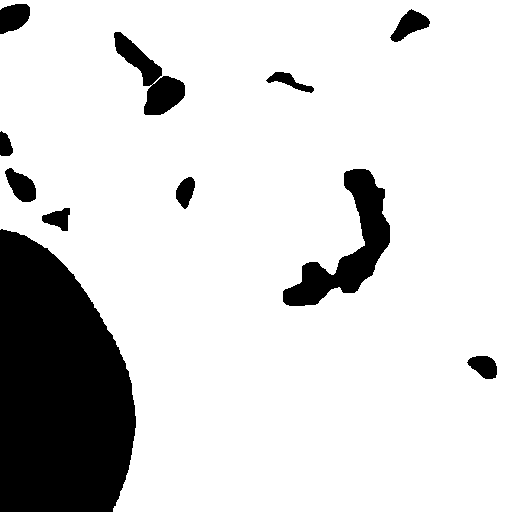

In [17]:
import matplotlib.pyplot as plt
# let's visualize the first instance (ignoring background)

instance_seg = mask_a[:,:,1] # green channel encodes instances
class_id_map = mask_a[:,:,0] # red channel encodes semantic category
class_labels = np.unique(class_id_map)
# let's visualize the first instance (ignoring background)
mask = (instance_seg == 0)
visual_mask = (mask * 255).astype(np.uint8)
print(np.max(visual_mask),np.min(visual_mask))
Image.fromarray(visual_mask)

In [18]:
np.unique(instance_seg)

array([0, 1, 2], dtype=uint8)

In [19]:
# create mapping between instance IDs and semantic category IDs
inst2class = {}
for label in class_labels:
    instance_ids = np.unique(instance_seg[class_id_map == label])
    inst2class.update({i: label for i in instance_ids})
print(inst2class)

{0: 0, 1: 1, 2: 2}


In [32]:
class_df = pd.DataFrame()
class_df["idx"] = [1,2,3]
class_df["Object Names"] = ["blood_vessel","glomerulus","unsure"]
# class_df.to_csv("../data/3class_names.csv",index = False)

In [21]:

from transformers import MaskFormerImageProcessor

processor = MaskFormerImageProcessor(reduce_labels=True, ignore_index=255, do_resize=False, do_rescale=False, do_normalize=False)

/home/tamukake/Github/HuBMAP/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tamukake/Github/HuBMAP/.venv/lib/python3.10/site-packages/transformers/models/maskformer/image_processing_maskformer.py:419: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(


In [22]:

import albumentations as A

ADE_MEAN = np.array([123.675, 116.280, 103.530]) / 255
ADE_STD = np.array([58.395, 57.120, 57.375]) / 255

transform = A.Compose([
    A.Resize(width=512, height=512),
    A.Normalize(mean=ADE_MEAN, std=ADE_STD),
])

In [23]:
image = cv2.imread("../data/train_images_class3/016c33dacfa1.png")
transformed = transform(image=np.array(image), mask=instance_seg)
pixel_values = np.moveaxis(transformed["image"], -1, 0)
instance_seg_transformed = transformed["mask"]
print(pixel_values.shape)
print(instance_seg_transformed.shape)

(3, 512, 512)
(512, 512)


In [24]:

np.unique(instance_seg_transformed)

array([0, 1, 2], dtype=uint8)

In [25]:
inputs = processor([pixel_values], [instance_seg_transformed], instance_id_to_semantic_id=inst2class, return_tensors="pt")

In [26]:

import torch

for k,v in inputs.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,[x.shape for x in v])
     

pixel_values torch.Size([1, 3, 512, 512])
pixel_mask torch.Size([1, 512, 512])
mask_labels [torch.Size([2, 512, 512])]
class_labels [torch.Size([2])]


In [27]:
assert not torch.allclose(inputs["mask_labels"][0][0], inputs["mask_labels"][0][1])

In [28]:

inputs["class_labels"]

[tensor([0, 1])]

In [29]:
data = pd.read_csv("../data/3class_names.csv")
id2label = {id: label.strip() for id, label in enumerate(data["Object Names"])}

Label: blood_vessel


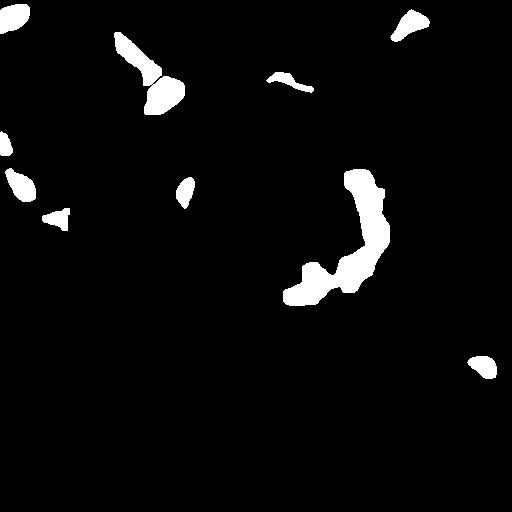

In [30]:

from PIL import Image

# visualize first one
print("Label:", id2label[inputs["class_labels"][0][0].item()])

visual_mask = (inputs["mask_labels"][0][0].numpy() * 255).astype(np.uint8)
Image.fromarray(visual_mask)